# Word embedding - Solutions

In this tutorial we will be working with the transcriptions of general debates at the United Nations from 1970 to 2016. We will try to see whether the fall of the iron curtain changed the debates.

For now, we'll just focus on the representation of the general debeates using various methods.

## Packages

In [1]:
InstallPackages = False
if InstallPackages:
    !pip install pandas
    !pip install numpy
    !pip install scikit-learn
    !pip install spacy
    !pip install gensim
    !pip install seaborn
    !pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from gensim.corpora import Dictionary
import spacy
from gensim.models.fasttext import load_facebook_model
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

**Note:** Please, download the .bin file from the following website: https://fasttext.cc/docs/en/crawl-vectors.html

In [3]:
ft_model = load_facebook_model('Models/cc.en.300.bin')
ft_dim = 300

## Seed

In [4]:
seed = 42

## Read the Data
Read in the pre-processed 02.1 un-general-debates.csv file and set it to a data frame called df.

In [5]:
df = pd.read_csv('Data/03.1 un-general-debates.csv')

Use info on df

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   session   7507 non-null   int64 
 1   year      7507 non-null   int64 
 2   country   7507 non-null   object
 3   text      7507 non-null   object
 4   document  7507 non-null   object
dtypes: int64(2), object(3)
memory usage: 293.4+ KB


Check the head of ad_data

In [7]:
df.head()

,session,year,country,text,document
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...,indeed pleasure member delegation extend ambas...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ...",may begin congratulate sir election presidency...
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ...",mr president particular pleasure behalf delega...
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...,debate fortieth session general assembly four ...
4,44,1989,ZWE,﻿I should like at the outset to express my del...,like outset express delegation satisfaction pl...


Now, we will focus on the German states, the United states of America and Russia

In [8]:
where = df['country'].isin(['DDR','DEU','USA','RUS'])

In [9]:
df = df[where]

In [10]:
df = df.reset_index(drop=True)

## Exercise 1 - Write functions to vectorize the documents

Vectorize function

In [11]:
def vectorize(docs):
    
    """
    This function is used to vectorize the corpus.
    
    """
    
    vectorized = []
    for tokens in docs:
        zero_vector = np.zeros(ft_dim)
        vectors = []
        for token in tokens:
            if token in ft_model.wv.key_to_index:
                try:
                    vectors.append(ft_model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            vectorized.append(avg_vec)
            """
            if len(tokens) > 1:
                print('tokens:', tokens)
                for i, vec in enumerate(vectors):
                    print('vec for %s:' % tokens[i], vec)
                print('avg:', avg_vec)
                print('val for avg[0]:', avg_vec[0])
                temp = [x[0] for x in vectors]
                print('first vals:', temp)
                print('avg first vals:', numpy.mean(temp))
            """
        else:
            vectorized.append(zero_vector)
    return vectorized

## Exercise 2 - Conduct the vectorization of the documents

Not it's time to conduct the vectorization of the documents and to see the dimension of the vectorization as well as the number of documents vectorized.

In [12]:
vectorized = vectorize(df['document'])

In [13]:
#representation of a document
len(vectorized[1])

300

In [14]:
#number of documents
len(vectorized)

152

Add topics over documents to Data Frame

## Exercise 3 - Add topics over documents to the data frame

Add vectors to Data Frame

In [15]:
pd.DataFrame(list(map(np.ravel, vectorized)))

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.041803,-0.474364,-0.177181,-0.115030,0.064566,0.080548,-0.432402,0.023970,0.002197,0.005664,...,0.054978,-0.011042,-0.422587,0.117365,-0.045470,0.060640,0.070408,0.433676,-0.180066,-0.006274
1,0.045170,-0.479347,-0.176777,-0.114831,0.058033,0.077568,-0.435678,0.026247,0.000754,0.005336,...,0.054311,-0.012711,-0.420422,0.120504,-0.047409,0.063532,0.071119,0.437064,-0.180782,-0.006327
2,0.042098,-0.477911,-0.177789,-0.111894,0.065718,0.085932,-0.438042,0.016039,-0.001096,0.008730,...,0.047986,-0.007814,-0.423469,0.119311,-0.038719,0.060234,0.067308,0.430105,-0.182800,0.004314
3,0.040613,-0.473045,-0.178341,-0.113857,0.065143,0.076385,-0.427757,0.025394,0.000688,0.005907,...,0.056330,-0.014192,-0.422098,0.120440,-0.044725,0.063443,0.071703,0.433857,-0.181058,-0.005857
4,0.039868,-0.468658,-0.175847,-0.115713,0.068617,0.079759,-0.427061,0.021308,0.001091,0.005531,...,0.050403,-0.012078,-0.421168,0.113696,-0.041331,0.061586,0.071667,0.439560,-0.177153,-0.003478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0.041443,-0.472530,-0.179367,-0.114636,0.064991,0.076231,-0.428124,0.026487,0.000383,0.004232,...,0.058600,-0.015615,-0.421761,0.119955,-0.043128,0.061627,0.071682,0.435125,-0.180907,-0.008896
148,0.044541,-0.473861,-0.176111,-0.113395,0.065062,0.073943,-0.434651,0.023403,0.000180,0.006896,...,0.052061,-0.010522,-0.423800,0.118548,-0.041915,0.066871,0.069289,0.435122,-0.181913,-0.004838
149,0.043971,-0.471412,-0.176335,-0.110895,0.066081,0.074975,-0.422528,0.026734,0.002478,0.006643,...,0.060910,-0.019040,-0.428539,0.118366,-0.040926,0.064805,0.069541,0.426809,-0.173203,-0.005083
150,0.047017,-0.470673,-0.177591,-0.110135,0.060646,0.072362,-0.430308,0.024766,0.000785,0.008610,...,0.058805,-0.014152,-0.424705,0.119273,-0.039459,0.065795,0.067146,0.437436,-0.178875,-0.003260


In [16]:
df = pd.concat([df,pd.DataFrame(list(map(np.ravel, vectorized)))], axis=1)

In [17]:
df.head()

,session,year,country,text,document,0,1,2,3,4,...,290,291,292,293,294,295,296,297,298,299
0,44,1989,RUS,﻿My task as head of the delegation of the Sovi...,task head delegation soviet union general asse...,0.041803,-0.474364,-0.177181,-0.115030,0.064566,...,0.054978,-0.011042,-0.422587,0.117365,-0.045470,0.060640,0.070408,0.433676,-0.180066,-0.006274
1,44,1989,DEU,"﻿\nI congratulate you, Sir, on your election a...",congratulate sir election president general as...,0.045170,-0.479347,-0.176777,-0.114831,0.058033,...,0.054311,-0.012711,-0.420422,0.120504,-0.047409,0.063532,0.071119,0.437064,-0.180782,-0.006327
2,44,1989,USA,﻿I am honoured to address the General Assembly...,honour address general assembly today beginnin...,0.042098,-0.477911,-0.177789,-0.111894,0.065718,...,0.047986,-0.007814,-0.423469,0.119311,-0.038719,0.060234,0.067308,0.430105,-0.182800,0.004314
3,44,1989,DDR,"﻿May I congratulate you, Sir, on your election...",may congratulate sir election president forty ...,0.040613,-0.473045,-0.178341,-0.113857,0.065143,...,0.056330,-0.014192,-0.422098,0.120440,-0.044725,0.063443,0.071703,0.433857,-0.181058,-0.005857
4,25,1970,USA,1.\t It is my privilege to extend to you once ...,1 privilege extend warm congratulation united ...,0.039868,-0.468658,-0.175847,-0.115713,0.068617,...,0.050403,-0.012078,-0.421168,0.113696,-0.041331,0.061586,0.071667,0.439560,-0.177153,-0.003478


## Exercise 4 - Write functions to find the number of clusters using k-means

**Note:** Get the number of clusters using the elbow method.

In [18]:
def elbow_method(Y_sklearn):
    
    """
    This function is used to get the optimal number of clusters in order to feed to the k-means clustering algorithm.
    
    """
    
    #algorithm{“lloyd”, “elkan”, “auto”, “full”}, default=”lloyd” per default: The classical EM-style algorithm is "lloyd".

    number_clusters = range(1, 11)  # Range of possible clusters that can be generated
    kmeans = [KMeans(n_clusters=i, max_iter = 600,random_state=seed) for i in number_clusters] # Getting no. of clusters 

    score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))] # Getting score corresponding to each cluster.
    score = [i*-1 for i in score] # Getting list of positive scores.
    
    #score = sum of distances of samples to their closest cluster center. distance = euclidian distance
    
    plt.locator_params(axis='y', nbins=12)
    plt.locator_params(axis='x', nbins=10)
    
    plt.plot(number_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Distances')
    #plt.title('Elbow Method')
    plt.show()

## Exercise 5 - Conduct the k-means, add it to the data frame 

Now, it's time to conduct the k-means.

First, find the number of clusters.

Second, build the model.

Third, add it to the data frame.

In [19]:
#find the number of clusters
#elbow_method(df.loc[:, '0':'299'])

In [20]:
#number of clusters: result from elbow method
nclusters = 2

In [21]:
#build k means model
km = KMeans(n_clusters=nclusters, init='k-means++', max_iter=600, random_state=seed, n_init=10).fit(vectorized)

C:\Users\Maximilian Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [22]:
#documents to cluster assignment
km.labels_

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0])

In [23]:
df['k_means_cluster']=km.labels_

## Exercise 6 - See what are the top n tokens in each cluster

*Hint:* You may write a function returning you the top n tokens in each cluster

In [24]:
def get_top_n_words(corpus, n=None):
    
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    """
    vec = CountVectorizer(token_pattern = r"(?u)\b\w+\b").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [25]:
common_words = get_top_n_words(df.loc[km.labels_==1]['document'], 20)
for word, freq in common_words:
    print(word, freq)

united 2077
states 1736
nations 1490
international 1409
world 1177
people 1080
peace 1014
country 960
security 946
soviet 894
nuclear 890
weapon 709
union 708
would 688
must 685
state 624
make 618
republic 607
war 570
general 560


## Exercise 7 - Visualize the k-means

**Note:** You may use a PCA with two components to visualize the k-means

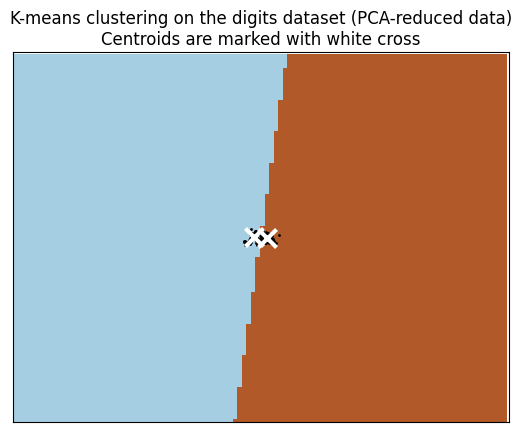

In [26]:
reduced_data = PCA(n_components=2).fit_transform(vectorized)
kmeans = KMeans(init="k-means++", n_clusters=nclusters, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()